In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")


*Loading Data*

In [ ]:
from quantrocket.license import set_license
set_license("93c815d1-e078-11ee-80c7-2f600d78117c")

{'licensekey': '93c8........117c', 'software_license': {}}

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid', 'Symbol', 'Exchange'], vendors='usstock')
securities

,Symbol,Exchange
Sid,,
FIBBG000B9XRY4,AAPL,XNAS


In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock-free1",free = True)

{'status': 'success', 'msg': 'successfully created usstock-free1 bundle'}

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock-free1")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
from quantrocket import get_prices
data = get_prices("usstock-free1", data_frequency='daily', sids="FIBBG000B9XRY4", start_date='2023-01-01', end_date='2023-12-31', fields=["Close"])

In [ ]:
data.to_csv('usstockaapl.csv')

In [ ]:
data=pd.read_csv('usstockaapl.csv')
data

,Field,Date,FIBBG000B9XRY4
0,Close,2023-01-03,124.375
1,Close,2023-01-04,125.658
2,Close,2023-01-05,124.325
3,Close,2023-01-06,128.900
4,Close,2023-01-09,129.427
...,...,...,...
245,Close,2023-12-22,193.600
246,Close,2023-12-26,193.050
247,Close,2023-12-27,193.150
248,Close,2023-12-28,193.580


In [ ]:
data.rename(columns={"FIBBG000B9XRY4":"Close"},inplace=True) #Changing the Column Name

**Class Description:**

A class to model the behavior of a financial market based on daily closing prices.

**Attributes:**

- **data (DataFrame):** The financial data containing 'Date' and 'Close' columns.
- **returns (list):** List to store daily returns.
- **state (list):** List to store market states (1 for bull, 0 for flat, -1 for bear).
- **portfolio_values (list):** List to store portfolio values over time.
- **optimal_buys (list):** List to store indices of optimal buying opportunities.

**Function Definitions:**

- **calculate_state():**
    Calculate daily returns and determine market states based on returns.

- **calculate_portfolio_values():**
    Calculate portfolio values based on market states and store optimal buying indices.

- **visualize_transition_probability():**
    Visualize the transition probability distribution between different market states.

- **decide_buy():**
    Decide whether to buy stock based on the change in portfolio value.


In [ ]:
import pandas as pd
data=pd.read_csv('/content/file1.csv')
data.rename(columns = {'FIBBG000B9XRY4':'Close'}, inplace = True)
data.drop(['Field'],axis=1,inplace=True)
data

,Date,Close
0,2023-01-03,124.375
1,2023-01-04,125.658
2,2023-01-05,124.325
3,2023-01-06,128.900
4,2023-01-09,129.427
...,...,...
245,2023-12-22,193.600
246,2023-12-26,193.050
247,2023-12-27,193.150
248,2023-12-28,193.580


In [67]:
class Model:
    def __init__(self, data):
        self.data = data
        self.returns = []
        self.state = []
        self.portfolio_values = [0]
        self.optimal_buys=[]
        self.transition_counts= {
            -1: {-1: 0, 0: 0, 1: 0},
            0: {-1: 0, 0: 0, 1: 0},
            1: {-1: 0, 0: 0, 1: 0}}
        self.transition_probabilities= {
            -1: {-1: 0, 0: 0, 1: 0},
            0: {-1: 0, 0: 0, 1: 0},
            1: {-1: 0, 0: 0, 1: 0}}
    def calculate_state(self):
        self.state.append(0)
        for i in range(1, len(self.data)):
            rd = (self.data.iloc[i]['Close'] - self.data.iloc[i - 1]['Close']) / self.data.iloc[i - 1]['Close']
            self.returns.append(rd)
            if rd >= 0.01:
                self.state.append(1)
            elif rd > (-1 * 0.01):
                self.state.append(0)
            else:
                self.state.append(-1)
    def update_portfolio_values(self,decision,index):
      if decision==1:
            if self.state[index] == 1 and self.state[index - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[index - 1] + 1)
            elif self.state[index] == -1 and self.state[index - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[index - 1] - 1)
            else:
                self.portfolio_values.append(self.portfolio_values[index - 1])
            self.optimal_buys.append(index)
      else:
          self.portfolio_values.append(self.portfolio_values[index - 1])
    def update_transition_counts(self, prev_state, current_state):
          self.transition_counts[prev_state][current_state] += 1
    def calculate_transition_probabilities(self):
        for prev_state, transitions in self.transition_counts.items():
            total_transitions = sum(transitions.values())
            if total_transitions == 0:
                continue
            self.transition_probabilities[prev_state] = {
                next_state: count / total_transitions
                for next_state, count in transitions.items()
            }
    def decide_buy_or_not(self):
      self.calculate_state()
      for i in range(1, len(self.state)):
        self.calculate_transition_probabilities()
        prob_increase = self.transition_probabilities[self.state[i]].get(1, 0)
        prob_decrease = self.transition_probabilities[self.state[i]].get(-1, 0)
        if prob_increase > prob_decrease:
              decision = 1
        else:
              decision = 0
        self.update_portfolio_values(decision,i)
        self.update_transition_counts(self.state[i-1],self.state[i])
      print("Transition Probability matrix:",self.transition_probabilities)
      l=[]
      for i in self.optimal_buys:
        l.append(data.iloc[i]['Date'])
      print('Optimal Buys :',l)
      print("portfolio_value :",self.portfolio_values[-1])

In [68]:
model=Model(data)

In [69]:
model.decide_buy_or_not()

Transition Probability matrix: {-1: {-1: 0.14285714285714285, 0: 0.7428571428571429, 1: 0.11428571428571428}, 0: {-1: 0.1464968152866242, 0: 0.5923566878980892, 1: 0.2611464968152866}, 1: {-1: 0.125, 0: 0.6785714285714286, 1: 0.19642857142857142}}
Optimal Buys : ['2023-01-09', '2023-01-10', '2023-01-12', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-14', '2023-02-16', '2023-02-17', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-15', '2023-03-17', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04

In [58]:
#plot for data


1      0.010316
2     -0.010608
3      0.036799
4      0.004088
5      0.004450
         ...   
245   -0.005548
246   -0.002841
247    0.000518
248    0.002226
249   -0.005424
Name: Close, Length: 249, dtype: float64


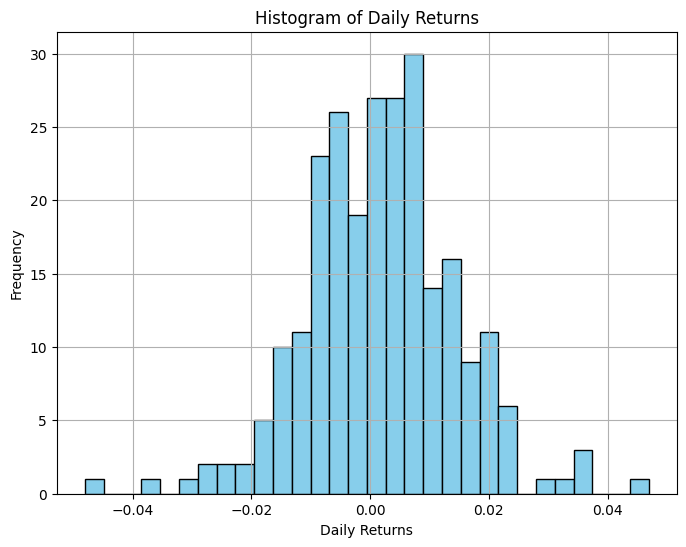

In [ ]:
# Calculate daily returns
daily_returns = data['Close'].pct_change().dropna()
print(daily_returns)
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


***Plot :The percentage change in stock prices over time***

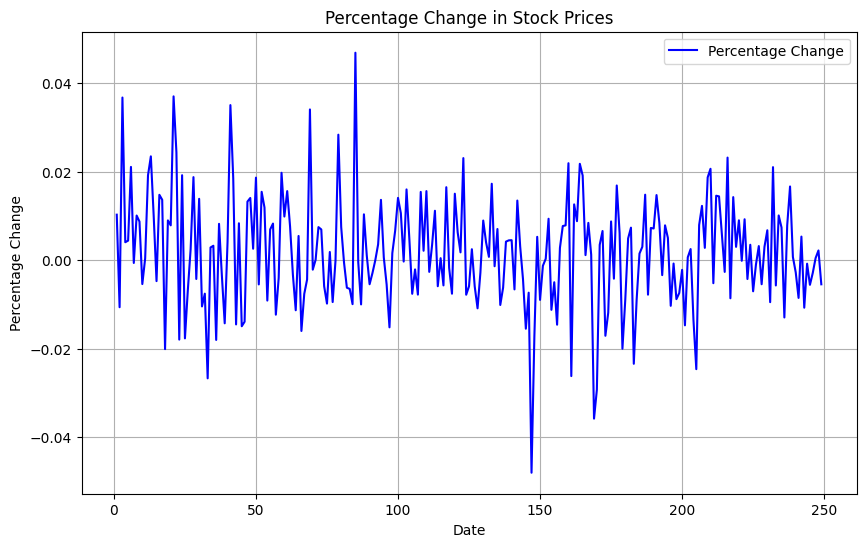

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot( data['Close'].pct_change(), label='Percentage Change', color='blue')
plt.title('Percentage Change in Stock Prices')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid(True)
plt.show()
